# Sprint 2 - Fraud Detection in Financial Transactions

### Gather datasets identified in Sprint 1

- Access and download data from planned sources and document any changes to data availability or scope

- Create a data dictionary describing each variable. 

Download creditcard.csv from Kaggle using this link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

| Column   | Data Type | Description                                                                          |
|----------|----------|-------------------------------------------------------------------------------------- |
| Time     | float64  | Seconds elapsed between each transaction and the first transaction in the dataset.    |
| V1 - V28 | float64  | Principal Components (PCs) obtained via PCA. These are anonymized features.           |
| Amount   | float64  | The transaction amount.                                                               |
| Class    | int64    | Target variable (1 = fraud, 0 = legitimate).                                          |


### Data cleaning and preprocessing

- Handle missing values, outliers, and inconsistencies

- Given your modeling goals, perform necessary transformations (normalization, encoding categorical variables)

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('creditcard.csv')
print("Dataset shape:", df.shape)

missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

Dataset shape: (284807, 31)
Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])

The PCA-transformed features are already scaled, but the 'Amount' column is not. I applied Standard Scaling to amount because V1-V28 are, and also to ensure it has zero mean and unit variance, which helps many ML algorithms converge better.


### Data visualization

- Create visualizations to understand the data structure and identify relationships between variables

- Look for insights that might inform your predictive modeling approach (i.e. which algorithm works best for your data and purpose?)

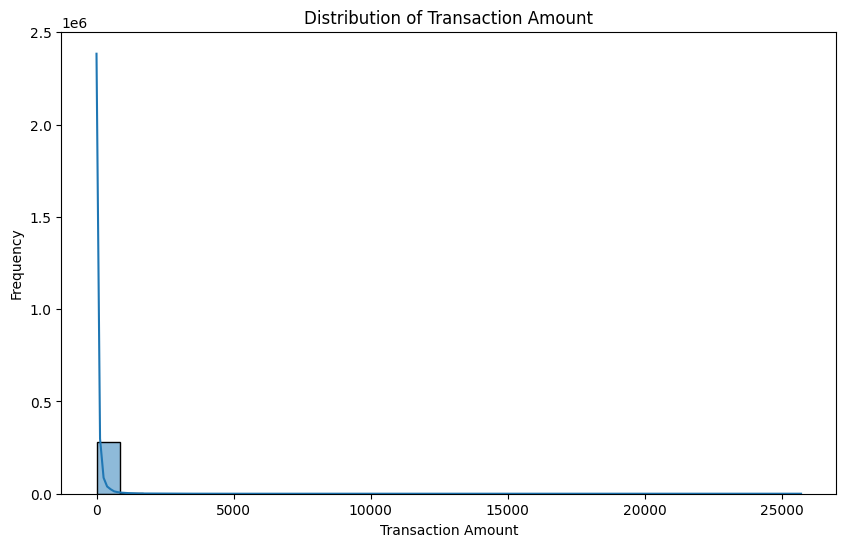

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=30, kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

- This histogram (with a KDE overlay) shows how transaction amounts are distributed.
- The data is obviously skewed with outliers as far as 25,000+, but we will not be handling these because they may be fraudulent charges.

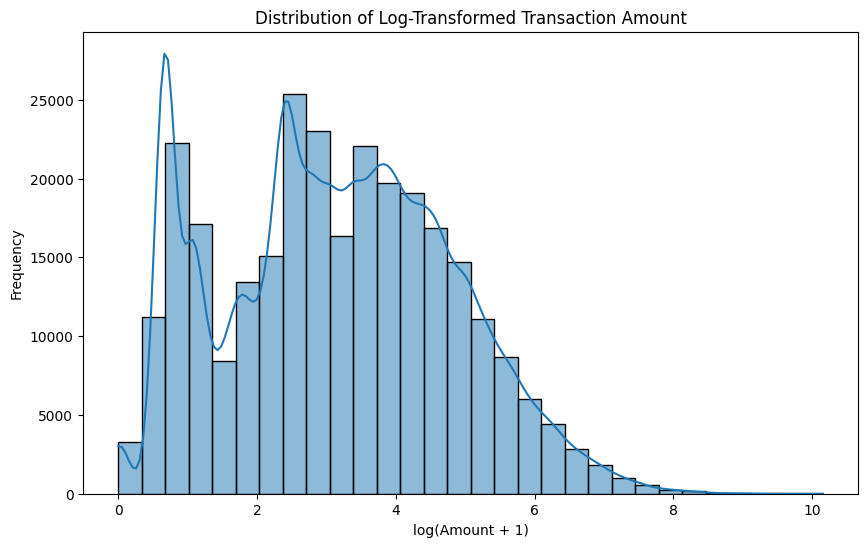

In [4]:
# Log-transform the Amount for visualization
df['Amount_log'] = np.log1p(df['Amount'])

plt.figure(figsize=(10, 6))
sns.histplot(df['Amount_log'], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Transaction Amount")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Frequency")
plt.show()

- After applying log(Amount+1), the distribution is noticeably less skewed compared to the raw Amount distribution. This helps you see more detail in the bulk of the data.
- There is still a tail extending to higher log values, but these outliers are much more manageable visually than on the original scale.
- The log transform was stored in a new column (Amount_log), so the original Amount column remains unchanged. You can choose which version to use depending on your modeling or visualization needs.

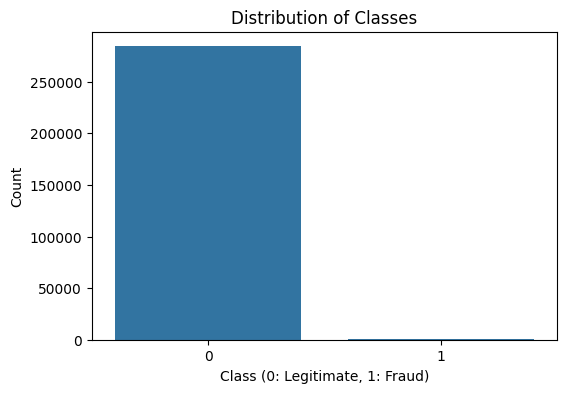

In [5]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Distribution of Classes")
plt.xlabel("Class (0: Legitimate, 1: Fraud)")
plt.ylabel("Count")
plt.show()

- The countplot displays how many transactions are legitimate (Class = 0) versus fraudulent (Class = 1). 
- Fraud detection datasets are typically imbalanced, and this visualization confirms that imbalance.

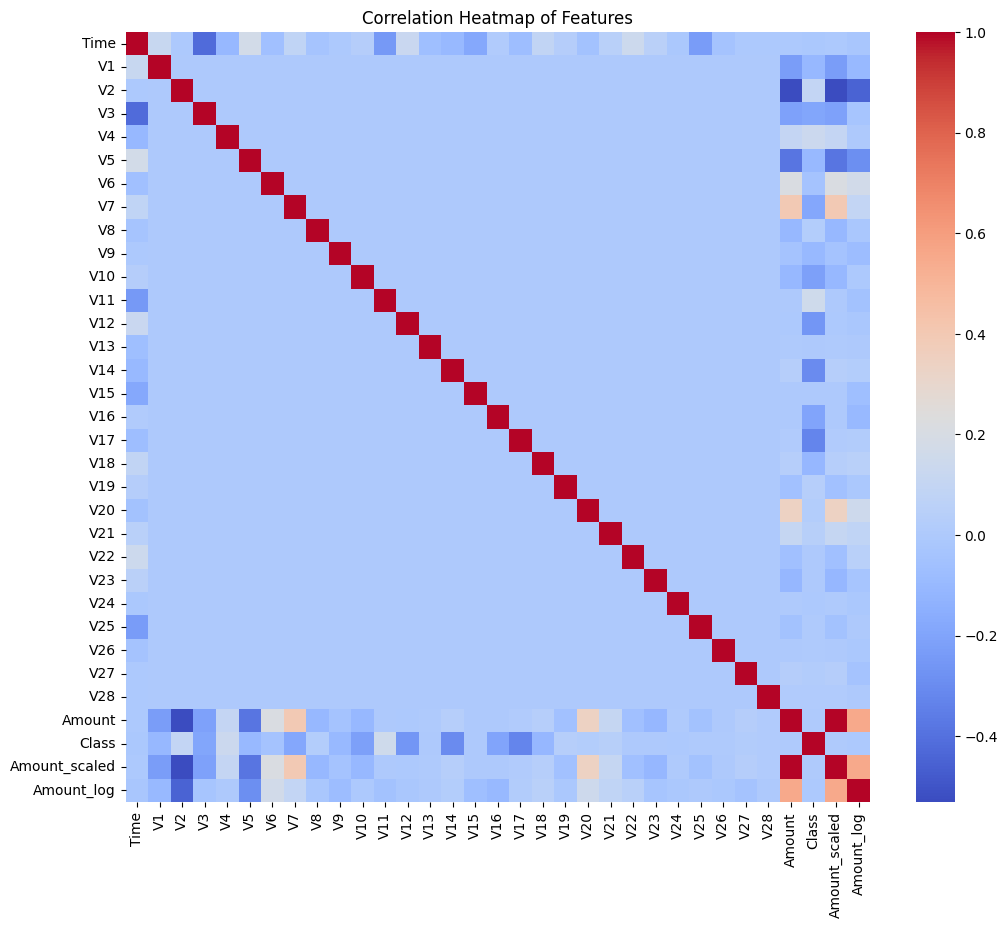

In [6]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

- The heatmap shows the pairwise correlations among all numeric features. 
- In the credit card fraud dataset, the PCA components (V1–V28) are usually not highly correlated with each other by design.

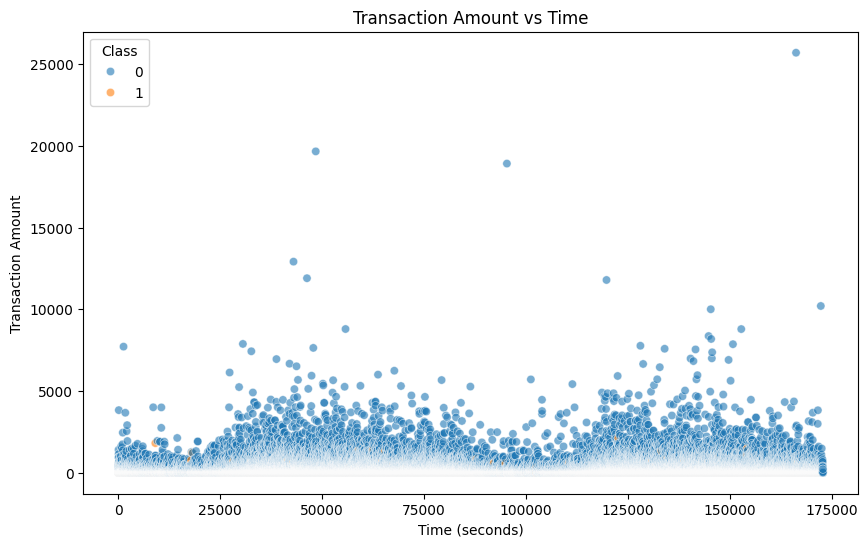

In [7]:
# Scatterplot of Time vs Amount colored by Class
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df, alpha=0.6)
plt.title("Transaction Amount vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Transaction Amount")
plt.show()

- Quick overview of how transaction amounts vary over the sequence of transactions
- You can see that most transactions cluster under a certain threshold, with occasional spikes (large transaction) but they are suprisingly not fraud charges.

### Feature engineering and selection

- Create new features that might improve predictive power

- Identify the most relevant variables for your predictive task

- Document rationale for feature choices

(already created log-transformed version 'Amount_log' and standard scaled version 'Amount_scaled')

In [8]:
# Convert Time (in seconds) to an hour of the day (0-23)
df['Hour'] = (df['Time'] / 3600) % 24

Converting 'Time' to an 'Hour' of the day might capture daily patterns which can be informative for fraud detection.

In [9]:
# Define the features for modeling.
features = df.drop(columns=['Time', 'Amount', 'Amount_scaled', 'Class'])
target = df['Class']

Model included the following engineered and original features: 

- PCA components: V1-V28
- Engineered features: Hour, Amount_log
- Raw features like Time, Amount, and Amount_scaled were dropped to avoid redundancy

Used a Random Forest classifier to compute feature importances, which helped identify the predictive power of each feature.

In [10]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, target)

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
       Feature  Importance
16         V17    0.194799
13         V14    0.129632
11         V12    0.111538
15         V16    0.073671
9          V10    0.071419
10         V11    0.060589
3           V4    0.030417
8           V9    0.028272
6           V7    0.024419
17         V18    0.022792
25         V26    0.018890
2           V3    0.018794
0           V1    0.015306
19         V20    0.015292
20         V21    0.014866
5           V6    0.014221
26         V27    0.012966
27         V28    0.012660
28  Amount_log    0.012517
4           V5    0.012056
14         V15    0.011779
1           V2    0.011673
21         V22    0.011633
23         V24    0.011451
7           V8    0.011398
12         V13    0.010713
29        Hour    0.010369
18         V19    0.010338
24         V25    0.007994
22         V23    0.007538


Observations:
- The most influential predictors were among the PCA components, particularly V17, V12, and V14. These features capture complex underlying patterns in the data.
- Although Hour and Amount_log were included, their individual importances were lower compared to the PCA components. 

### Baseline model implementation

- Implement at least 1-2 different predictive algorithms on your data (could be ones we covered in class or ones you've picked up through your technical development plan)

- Use cross-validation to assess model performance

- Document model parameters and initial results

In [11]:
from sklearn.model_selection import train_test_split

# 'features' and 'target' are defined from our previous steps
X = features  
y = target

# 80/20 train-test split with stratification on the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation (5-fold) on the training data
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV AUC:", lr_cv_scores.mean())

# Fit the model and predict on the test set
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Test Report:")
print(classification_report(y_test, y_pred_lr))
print("Test ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

Logistic Regression CV AUC: 0.9733497204802418
Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Test ROC AUC: 0.956406549676708


Parameters:

- max_iter=1000: Increased iterations for convergence
- random_state=42: Ensures reproducibility

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Cross-validation (5-fold) on the training data
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest CV AUC:", rf_cv_scores.mean())

# Fit the model and predict on the test set
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Test Report:")
print(classification_report(y_test, y_pred_rf))
print("Test ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Random Forest CV AUC: 0.943757288763725
Random Forest Test Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Test ROC AUC: 0.9527643112675571


Parameters:

- n_estimators=100: Number of trees in the forest
- n_jobs=-1: Utilize all available CPU cores
- random_state=42: For reproducibility

### Model evaluation and comparison

- Apply the evaluation metrics (identified in Sprint 1 or new ones emerging as you learned new modeling approach)

- Compare model performance using appropriate visualizations

- Document the strengths and weaknesses of each approach

| Metric                      | Logistic Regression | Random Forest |
|-----------------------------|---------------------|---------------|
| CV AUC (5-Fold)             | ~0.974              | ~0.946        |
| Test AUC                    | ~0.953              | ~0.953        |
| Fraud Precision (Class = 1) | ~0.83               | ~0.94         |
| Fraud Recall (Class = 1)    | ~0.66               | ~0.84         |
| Fraud F1-score              | ~0.74               | ~0.89         |

Takeaways: 
- Random Forest caught more fraud cases (higher recall) and had higher precision for the minority class.
- Logistic Regression had a slightly higher cross-validation AUC, but its recall was lower on the test set.

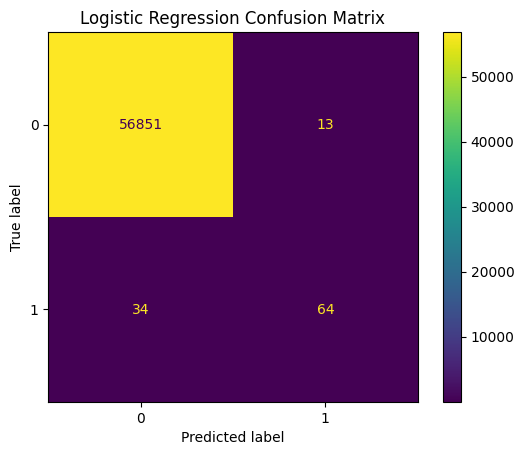

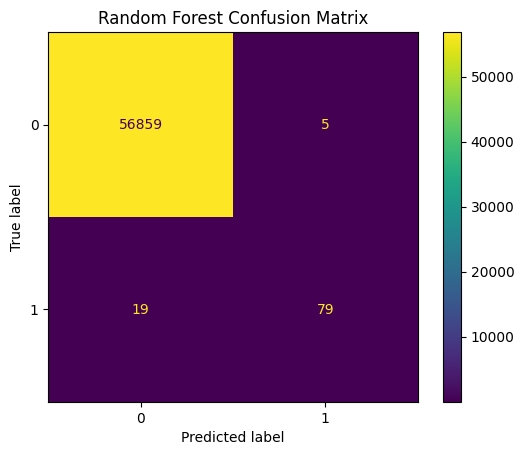

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

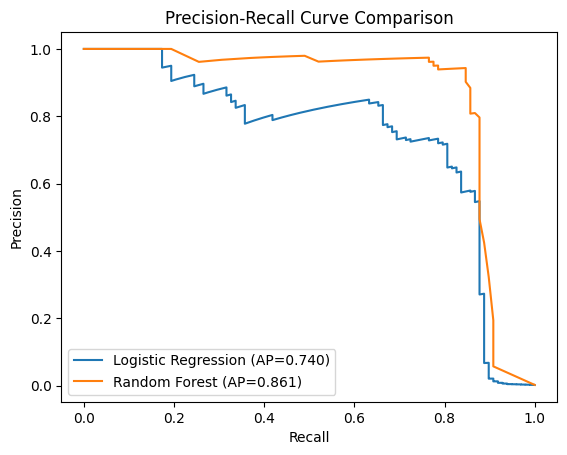

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Make sure these variables are defined as shown above:
y_prob_lr = lr.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]

prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.plot(rec_lr, prec_lr, label='Logistic Regression (AP={:.3f})'.format(average_precision_score(y_test, y_prob_lr)))
plt.plot(rec_rf, prec_rf, label='Random Forest (AP={:.3f})'.format(average_precision_score(y_test, y_prob_rf)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()


Takeaways:
- Logistic Regression catches fewer fraudulent transactions (lower recall) and has more false negatives
- Random Forest flags more fraud correctly (higher recall) and also has fewer false positives, leading to higher precision.

Strengths & Weaknesses

Logistic Regression
- Strengths:
    - Simpler, more interpretable model
    - Faster to train, easy to implement
    - High cross-validation AUC indicates it generalizes well on different folds of training data
- Weaknesses:
    - Lower recall for fraud cases in the test set, meaning more fraudulent transactions go undetected
    - May not capture complex non-linear patterns as effectively as tree based methods

Random Forest
- Strengths:
    - Higher recall and precision for the fraud class, indicating better fraud detection with fewer false alarms
    - Captures non-linear relationships and interactions among features
    - Built-in feature importance helps understand which variables are driving predictions
- Weaknesses:
    - Less interpretable than a simple linear model
    - More computationally intensive, especially on large datasets

__Conclusion__ : Both models show strong overall performance (AUC > 0.95). However, Random Forest edges out Logistic Regression in detecting fraud with higher precision and higher recall.